# Task 2 Solution

The problem we're tryong to solve can be broke down into the following steps:<br>
1- Make pre-processing on the input classical dataset to preparing it for the encoding process. <br>
2- Perform the encoding step, as a first thought, I am going to use an angle encoding technique. <br>
3- Design the QNN training circuit. <br>
4- Run the training and testing and deduce the classifiction accuracy.<br>
5- Revisit the model to fine tune the accuracy value.<br>
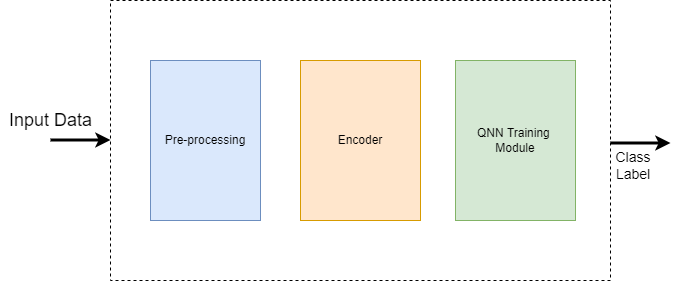
<br>
First the classical dataset shall be loaded <br>

In [51]:
import pandas as pd
train_data= pd.read_csv("mock_train_set.csv", delimiter=',')
train_data

,0,1,2,3,4
0,2789.26,1000.0,10.0,20.0,0.0
1,4040.01,1000000.0,1.0,1.0,1.0
2,2931.20,10000.0,10000.0,40.0,1.0
3,3896.54,10000.0,100000.0,30.0,1.0
4,982.06,100.0,1000.0,75.0,0.0
...,...,...,...,...,...
295,1464.52,1000000.0,10000.0,45.0,1.0
296,3493.66,1000000.0,100000.0,85.0,1.0
297,4182.81,1.0,1.0,65.0,0.0
298,3113.75,10000.0,100.0,1.0,1.0


In [52]:
test_data= pd.read_csv("mock_test_set.csv", delimiter=',')
test_data

,0,1,2,3,4
0,2988.55,10000.0,10000.0,75.0,1.0
1,3413.80,1.0,100.0,90.0,0.0
2,3891.52,1.0,1.0,5.0,0.0
3,4514.99,10000.0,1000000.0,25.0,1.0
4,752.29,10.0,10.0,90.0,0.0
...,...,...,...,...,...
115,3155.94,10000.0,10000.0,35.0,1.0
116,2795.04,1.0,10.0,45.0,0.0
117,3702.48,1.0,1.0,20.0,0.0
118,2790.57,1.0,1.0,40.0,0.0


In [53]:
train_data.columns

Index(['0', '1', '2', '3', '4'], dtype='object')

In [54]:
train_data["0"].shape

(300,)

In [55]:
col_0=train_data["0"]

In [56]:
import numpy as np
np.max(col_0)

4995.61

In [57]:
np.max(train_data["1"])

1000000.0

In [58]:
np.max(train_data["2"])

1000000.0

In [59]:
np.max(train_data["3"])

90.0

In [60]:
norm_col_0 = col_0/(np.max(col_0))

In [61]:
norm_col_0.shape

(300,)

In [62]:
normalized_df=(train_data-train_data.min())/(train_data.max()-train_data.min())

In [63]:
dataset_array = normalized_df.to_numpy()
dataset_array.shape

(300, 5)

In [64]:
normalized_test_df = (test_data-test_data.min())/(test_data.max()-test_data.min())
test_dataset_array = normalized_test_df.to_numpy()
test_dataset_array.shape

(120, 5)

The first Encoding technique will be an Angle Encoding followed by pi/4 rotation around Y then Z axis as proposed in 

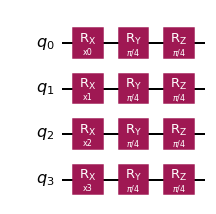

In [65]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer, QuantumCircuit
from qiskit.opflow import Z, I, StateFn
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap, TwoLocal, PauliFeatureMap
x0 = Parameter('x0')
x1 = Parameter('x1')
x2 = Parameter('x2')
x3 = Parameter('x3')
qc2 = QuantumCircuit(4)
qc2.rx(x0, 0)
qc2.rx(x1, 1)
qc2.rx(x2, 2)
qc2.rx(x3, 3)

qc2.ry(np.pi/4, 0)
qc2.ry(np.pi/4, 1)
qc2.ry(np.pi/4, 2)
qc2.ry(np.pi/4, 3)

qc2.rz(np.pi/4, 0)
qc2.rz(np.pi/4, 1)
qc2.rz(np.pi/4, 2)
qc2.rz(np.pi/4, 3)
feature_map= [qc2.bind_parameters({x0: x0_val})
            for x0_val in dataset_array[:, 0]]
feature_map= [qc2.bind_parameters({x1: x1_val})
            for x1_val in dataset_array[:, 1]]
feature_map= [qc2.bind_parameters({x2: x2_val})
            for x2_val in dataset_array[:, 2]]
feature_map= [qc2.bind_parameters({x3: x3_val})
            for x3_val in dataset_array[:, 3]]
qc2.draw('mpl', style='iqx')

Using PauliFeatureMap class to encode the classical data:

In [66]:

qc3 = PauliFeatureMap(4, reps=1, paulis=['ZZ'])

In the early days of Quantum Neural Network or Parametrized Circuits, they were implemented using randomized circuits. This approach led to a lot of challenges, for example Barren Pleateau, which prohibited the model to converge into an acceptable approximation to the true value of the classification label.
A predefined set of circuit templates are nowadays used in training, they generally formed of blocks consisting of alternating layers of rotation and entanglement as surveyed by Sim in here: https://arxiv.org/abs/1905.10876 <br>
The circuit expressibility can be used to select the ansatz design that is expeccted to give the highest prediction accuracy.
The QNN learning income is enhanced by reapeating the circuit blocks L times as suggested here: https://arxiv.org/abs/2006.14904

The two-local circuit is a parameterized circuit consisting of alternating rotation layers and entanglement layers: https://qiskit.org/documentation/stubs/qiskit.circuit.library.TwoLocal.html <br>
It can be used to implement the ansatz circuit that will do the training.
The reps parameter will be used to control how many layers will be used in our experiment. <br>
In our experiment, Circuit6 in https://arxiv.org/abs/1905.10876 which has the highest expressibility value for L=2 will be used here for training.

In [67]:
from qiskit.circuit import Parameter, ParameterVector
import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer, QuantumCircuit
from qiskit.opflow import Z, I, StateFn
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap, TwoLocal
dim =4
num_inputs=4
entangler_map_layer1 = [(1, 0), (3, 2)]
entangler_map_layer2 = [(2, 1)]
entanglement = [entangler_map_layer1, entangler_map_layer2]
ansatz = TwoLocal(dim, ['rx', 'rz'],'crz', entanglement, reps=4, skip_final_rotation_layer=True, insert_barriers=True) 

In [68]:
quantum_instance = QuantumInstance(Aer.get_backend('aer_simulator'), shots=1024)
algorithm_globals.random_seed = 42

The QNN model is constructed using a TwoLayerQNN class to integrate the encoding module and the training module.

In [69]:
from qiskit_machine_learning.neural_networks import TwoLayerQNN
opflow_qnn = TwoLayerQNN(num_inputs, feature_map = qc2, ansatz= ansatz, quantum_instance=quantum_instance)
#opflow_qnn = TwoLayerQNN(num_inputs, quantum_instance=quantum_instance)
print(opflow_qnn.circuit)

     ┌──────────────────────────────┐»
q_0: ┤0                             ├»
     │                              │»
q_1: ┤1                             ├»
     │  circuit-154922(x0,x1,x2,x3) │»
q_2: ┤2                             ├»
     │                              │»
q_3: ┤3                             ├»
     └──────────────────────────────┘»
«     ┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                                                                                                                                                                                     ├
«     │                                                                                                                                                                    

In [70]:
weights3 = algorithm_globals.random.random(opflow_qnn.num_weights)
# QNN maps inputs to [-1, +1]
opflow_qnn.forward(dataset_array[0, 0:4], weights3)

array([[0.03710938]])

In [71]:
opflow_qnn.backward(dataset_array[0, 0:4], weights3)

(None,
 array([[[-3.12500000e-02,  2.73437500e-02, -1.26953125e-02,
          -7.81250000e-03,  7.81250000e-03, -2.92968750e-02,
          -1.46484375e-02, -1.85546875e-02, -3.61328125e-02,
           3.36914063e-02,  1.75781250e-02, -1.85546875e-02,
          -2.34375000e-02,  1.36718750e-02,  4.00390625e-02,
           1.95312500e-02,  9.76562500e-03, -8.67361738e-19,
          -1.02539062e-02, -2.83203125e-02, -2.92968750e-02,
          -1.95312500e-03, -4.29687500e-02,  3.32031250e-02,
           2.34375000e-02,  2.63671875e-02,  9.76562500e-04,
           9.76562500e-04, -2.58789063e-02,  2.44140625e-02,
          -3.61328125e-02,  1.46484375e-02,  3.12500000e-02,
           2.34375000e-02, -1.26953125e-02, -1.95312500e-02,
          -2.92968750e-03, -2.05078125e-02]]]))

In [72]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    with open('loss_vals_qosf_cohort5.txt', 'w') as f:
        f.write(str(objective_func_vals).strip('[]').replace('\'', ''))
        np.save('loss_vals_qosf_cohort5.npy', objective_func_vals)

The NeuralNetworkClassifier is used to run the training and claculate the prediction accuracy.

In [73]:
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit.algorithms.optimizers import COBYLA
# cobnstruct neural network classifier
opflow_classifier = NeuralNetworkClassifier(opflow_qnn, optimizer=COBYLA())

In [74]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

training_labels = 2 * dataset_array[:, 4] - 1
test_labels = 2 * test_dataset_array[:, 4] - 1

# fit classifier to data
opflow_classifier.fit(dataset_array[:, 0:4] , training_labels)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
qnn_score = opflow_classifier.score(test_dataset_array[:, 0:4], test_labels)

with open('accuracy_vals_adhoc_zzfeaturemap.txt', 'a') as f:
    f.write(str(qnn_score)+' ') 
    np.save('accuracy_vals_adhoc_zzfeaturemap.npy', qnn_score)
print(f'QNN classification test score: {qnn_score}')

# predict labels
predicted = opflow_classifier.predict(test_dataset_array[:, 0:4])

QNN classification test score: 0.7833333333333333


| | Experiment #  | Used Encoder  | ansatz ID   | #LAYERS L   | Accuracy  |
|---:|:-------------|:-----------|:------|:------|:------|
| 1 | Experiment1 | Angle Enc.  | Circuit3  | 2   | 0.5917 |
| 2 | Experiment2 | Angle Enc. | Circuit3 | 3  | 0.8  | 
| 3 | Experiment3 | Angle Enc. |  Circuit3 | 4  |   0.7833| 
| 4 | Experiment4 | Angle Enc. |  Circuit6 | 3  |   0.8583| 

Conclusion: <br>
1- A highly expressive circuit is expected to achieve a higher prediction accuracy. <br>
2- Increasing the number of repeated blocks L leads to an increase in prediction accuracy then it is useless. <br>
3- The combination of a highly expressive circuit and using circuit blocks repetitions lead to enhancing the prediction accuracy. <br>


Future Work: <br>
1- Try more encoding type and ansatz designs to enhance the prediction accuracy with the guidelines explained above. <br>


In [77]:
from qiskit import *
qiskit.__qiskit_version__

{'qiskit-terra': '0.18.3', 'qiskit-aer': '0.8.2', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.14.0', 'qiskit-aqua': '0.9.2', 'qiskit': '0.27.0', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': '0.2.3', 'qiskit-machine-learning': '0.2.0'}